In [100]:
import os
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings
from langchain.text_splitter import TokenTextSplitter
from langchain.vectorstores import Chroma
from langchain_community.document_loaders import PyPDFLoader
from langchain.retrievers import BM25Retriever, EnsembleRetriever
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnablePassthrough
from langchain.chains import create_history_aware_retriever, create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_community.chat_message_histories import ChatMessageHistory
from langchain_core.chat_history import BaseChatMessageHistory
from langchain_core.runnables.history import RunnableWithMessageHistory
from google.colab import userdata

## LLM Config

In [101]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

llm = ChatOpenAI(
    model = "gpt-3.5-turbo",
    temperature = 0.5,
    max_tokens = 150
)

## Embedding Model Config

In [102]:
embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")

## PDF Loader

In [103]:
loader = PyPDFLoader("/content/Documents/ANN.pdf")

docs = loader.load()

In [104]:
# number of pages in the document
len(docs)

16

## Split Document into Chunks

In [105]:
text_splitter = TokenTextSplitter(
    chunk_size = 250,
    chunk_overlap = 50
)

In [106]:
splits = text_splitter.split_documents(docs)
len(splits)

29

## Semantic Search Retriever

In [107]:
vectorstore = Chroma.from_documents(documents=splits, embedding=embedding_model)

vectorstore_retriever = vectorstore.as_retriever(search_type='similarity', search_kwargs={'k': 2})

## Keyword Search Retriever

In [108]:
keyword_retriever = BM25Retriever.from_documents(splits, bm25params={'k1':2.0})

## Create Ensemble Search

In [109]:
ensemble_retriever = EnsembleRetriever(retrievers=[vectorstore_retriever, keyword_retriever], weights=[0.5, 0.5])

## Retriever with Chat History

In [110]:
# Creating prompt template
contextualized_prompt = ChatPromptTemplate.from_messages([
    ("system", "Use the history of the conversation and the user's most recent questions to provide accurate and relevant answers. Prioritize the user's latest query while incorporating historical context if it improves the response. Ensure clarity, relevance, and avoid redundancy."),
    MessagesPlaceholder('chat_history'),
    ("user", "{input}")
])

history_aware_retriever = create_history_aware_retriever(llm, ensemble_retriever, contextualized_prompt)

## Define Prompt Template

In [111]:
# Defining the message template

system_prompt = (
"You are a knowledgeable assistant. Answer the user's questions based solely on the provided context. If you don't know the answer, clearly state that you don't know. Do not make up answers or speculate."
"\n\n"
"{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history"),
        ("user", "{input}")
    ]
)

prompt

ChatPromptTemplate(input_variables=['chat_history', 'context', 'input'], input_types={'chat_history': list[typing.Annotated[typing.Union[typing.Annotated[langchain_core.messages.ai.AIMessage, Tag(tag='ai')], typing.Annotated[langchain_core.messages.human.HumanMessage, Tag(tag='human')], typing.Annotated[langchain_core.messages.chat.ChatMessage, Tag(tag='chat')], typing.Annotated[langchain_core.messages.system.SystemMessage, Tag(tag='system')], typing.Annotated[langchain_core.messages.function.FunctionMessage, Tag(tag='function')], typing.Annotated[langchain_core.messages.tool.ToolMessage, Tag(tag='tool')], typing.Annotated[langchain_core.messages.ai.AIMessageChunk, Tag(tag='AIMessageChunk')], typing.Annotated[langchain_core.messages.human.HumanMessageChunk, Tag(tag='HumanMessageChunk')], typing.Annotated[langchain_core.messages.chat.ChatMessageChunk, Tag(tag='ChatMessageChunk')], typing.Annotated[langchain_core.messages.system.SystemMessageChunk, Tag(tag='SystemMessageChunk')], typing.

## Create RAG Chain

In [112]:
# Creating question and answering chain
qa_chain = create_stuff_documents_chain(llm, prompt)

# Create the RAG chain
rag_chain = create_retrieval_chain(history_aware_retriever, qa_chain)

## Handle Session History

In [113]:
# Initialize store for session histories
store = {}

# Function to get session history for a given session ID
def get_session_history(session_id: str) -> BaseChatMessageHistory:
  if session_id not in store:
    store[session_id] = ChatMessageHistory()
  return store[session_id]

# Create Conversational RAG Chain with Session History
conversation_chain = RunnableWithMessageHistory(
    rag_chain,
    get_session_history,
    input_messages_key="input",
    history_messages_key="chat_history",
    output_messages_key="answer"
)

## Invoke Conversational Chain

In [114]:
response = conversation_chain.invoke(
    {"input":"What is ANN"},
    config={"configurable":{"session_id": "001"}}
)
response['answer']

'ANN stands for Artificial Neural Network. It is a computational model inspired by the biological neural networks in animal brains. Artificial Neural Networks consist of interconnected nodes, known as artificial neurons, that work together to perform complex computations. The structure of ANNs is based on the way biological neurons communicate with each other. They are used in machine learning to learn from data and make predictions or decisions.'

# Evaluating RAG Application

In [115]:
# get test dataset
import pandas as pd

dataset = pd.read_csv("/content/Documents/testdata.csv")

In [116]:
dataset.head()

,question,answer
0,Who introduced ANNs ?,ANNs introduced by the neurophysiologist Warre...
1,"What is an ""Artificial neural network""?","The term ""Artificial neural network"" refers to..."
2,How does the human brain store and process inf...,There are around 1000 billion neurons in the h...
3,What is meant by Hidden Layer of an artificial...,The hidden layer presents in-between input and...
4,"Who introduced ""Perceptron""?",Perceptron was introduced by Frank Rosenblatt ...


In [117]:
questions = dataset['question'].tolist()
ground_truth = dataset['answer'].tolist()

In [118]:
data = {"question":[], "answer":[], "contexts":[], "ground_truth":ground_truth}

In [119]:
# appending retrieved data to the dictionary
for query in questions:
  data["question"].append(query),
  data["answer"].append(conversation_chain.invoke({"input":query}, config={"configurable":{"session_id": "001"}})['answer'])
  data["contexts"].append([doc.page_content for doc in ensemble_retriever.get_relevant_documents(query)])

In [121]:
from datasets import Dataset
eval_dataset = Dataset.from_dict(data)

In [123]:
# import RAGAS to evaluate metrics
from ragas.metrics import context_precision, context_recall, answer_relevancy, faithfulness
from ragas import evaluate

result = evaluate(
    dataset = eval_dataset,
    metrics = [
        context_precision,
        context_recall,
        answer_relevancy,
        faithfulness
    ]
)

Evaluating:   0%|          | 0/28 [00:00<?, ?it/s]

In [124]:
result

{'context_precision': 0.9286, 'context_recall': 1.0000, 'answer_relevancy': 0.9529, 'faithfulness': 0.7639}

In [125]:
results = result.to_pandas()
results

,user_input,retrieved_contexts,response,reference,context_precision,context_recall,answer_relevancy,faithfulness
0,Who introduced ANNs ?,[1 \n \nArtificial Neural Network \n \nFrom Bi...,Artificial Neural Networks (ANNs) were first i...,ANNs introduced by the neurophysiologist Warre...,0.833333,1.0,0.875716,1.000000
1,"What is an ""Artificial neural network""?",[1 \n \nArtificial Neural Network \n \nFrom Bi...,"An ""Artificial neural network"" is a computatio...","The term ""Artificial neural network"" refers to...",0.833333,1.0,0.979310,0.833333
2,How does the human brain store and process inf...,"[, data is stored in \nsuch a manner as to be ...",The human brain stores and processes informati...,There are around 1000 billion neurons in the h...,1.000000,1.0,0.943250,0.777778
3,What is meant by Hidden Layer of an artificial...,[5 \n \nThe architecture of an artificial neur...,The hidden layer of an artificial neural netwo...,The hidden layer presents in-between input and...,1.000000,1.0,0.949852,0.500000
4,"Who introduced ""Perceptron""?",[6 \n \nPerceptron \nPerceptron was introduce...,Perceptron was introduced by Frank Rosenblatt ...,Perceptron was introduced by Frank Rosenblatt ...,0.833333,1.0,0.973653,0.666667
5,Please explain Single Layer Perceptron Model?,[8 \n \nHow Does Perceptron Work? \nAs discuss...,The Single Layer Perceptron model is one of th...,One of the easiest ANN (Artificial Neural Netw...,1.000000,1.0,0.948699,0.769231
6,What are the advantages of a Multi-Layered Per...,[ and bias values are modified per the model’s...,The advantages of a Multi-Layered Perceptron M...,A multi-layered perceptron model can solve com...,1.000000,1.0,1.000000,0.800000


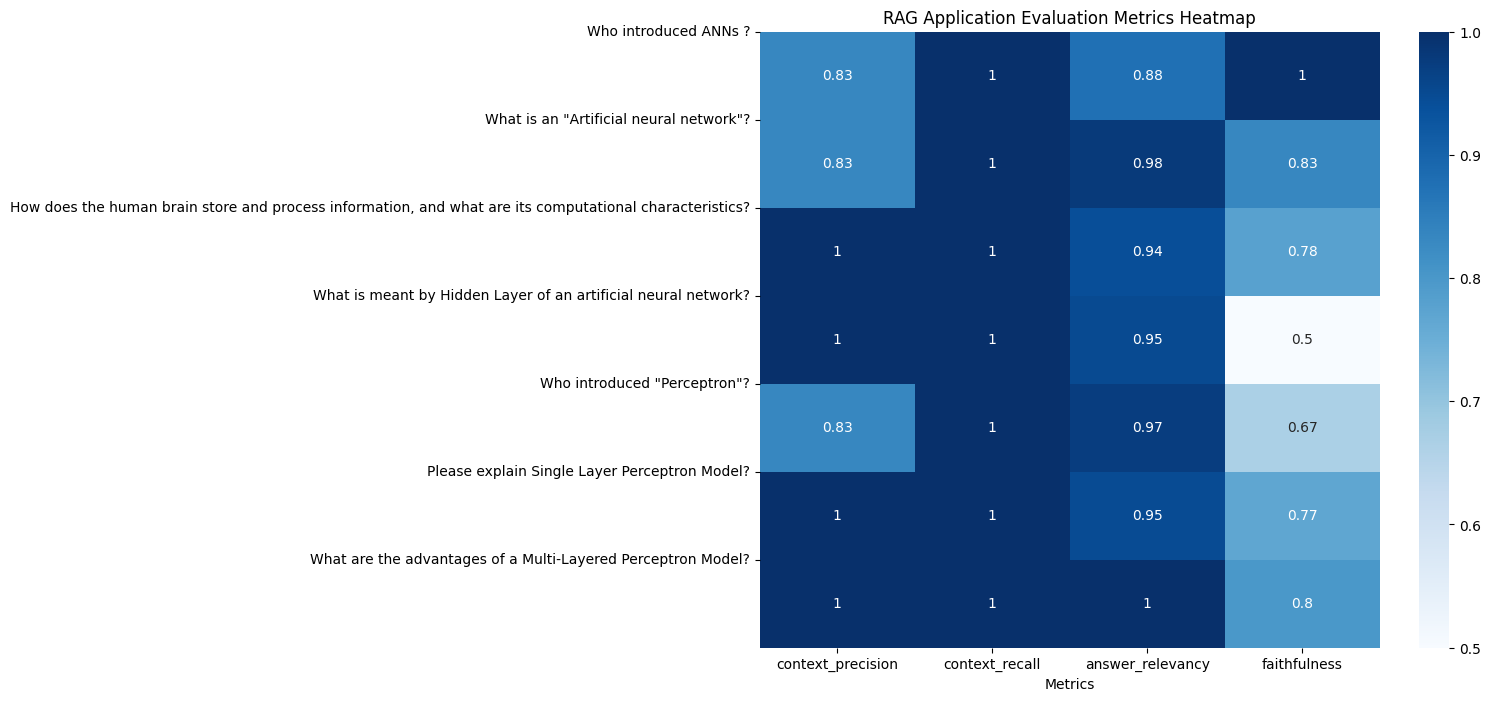

In [126]:
# visualizing results
import seaborn as sns
import matplotlib.pyplot as plt

heatmap_data = results[['context_precision', 'context_recall', 'answer_relevancy', 'faithfulness']]
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='Blues')
plt.title('RAG Application Evaluation Metrics Heatmap')
plt.yticks(ticks=range(len(data['question'])), labels=data['question'], rotation=0)
plt.xlabel('Metrics')
plt.show()
